# DATA PREPARATION

In [1]:
# IMPORT LIBRARY

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")

In [2]:
# CONNECT TO GDRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# LOAD DATASET

df = pd.read_excel('/content/drive/MyDrive/Skripsi/sale_data.xlsx')
df.head()

,UserID,InvoiceNo,TotalPayment,InvoiceDate
0,212645,10001,84.8799,2020-05-01
1,153801,10002,454.3857,2020-05-01
2,212653,10003,204.0957,2020-05-01
3,76145,10004,340.0299,2020-05-01
4,212636,10005,221.1057,2020-05-01


In [4]:
df.shape

(62295, 4)

In [5]:
df.dtypes

UserID                   int64
InvoiceNo                int64
TotalPayment           float64
InvoiceDate     datetime64[ns]
dtype: object

In [6]:
df.describe()

,UserID,InvoiceNo,TotalPayment
count,62295.000000,62295.000000,62295.000000
mean,213128.444145,41148.000000,525.118940
std,62478.156434,17983.161847,463.740111
min,-18822.000000,10001.000000,13.340700
25%,195819.000000,25574.500000,303.482700
50%,224386.000000,41148.000000,426.246300
75%,254759.000000,56721.500000,631.314000
max,295095.000000,72295.000000,32034.714300


In [7]:
# MISSING VALUES

df.isnull().sum()

UserID          0
InvoiceNo       0
TotalPayment    0
InvoiceDate     0
dtype: int64

# RFM MODELLING

In [8]:
Now = dt.datetime(2022,1,4)

In [9]:
df_recency = df.groupby(['UserID'],as_index=False)['InvoiceDate'].max()
df_recency.columns = ['UserID','Last_Purchase_Date']

df_recency['Recency'] = df_recency.Last_Purchase_Date.apply(lambda x:(Now - x).days)
df_recency.drop(columns=['Last_Purchase_Date'],inplace=True)
df_recency.head()

,UserID,Recency
0,-18822,583
1,-18786,452
2,-18639,452
3,-18511,338
4,-18405,668


In [10]:
FM_Table = df.groupby('UserID').agg({'InvoiceNo'   : lambda x:len(x),
                                         'TotalPayment'  : lambda x:x.sum()})
FM_Table.rename(columns = {'InvoiceNo' :'Frequency',
                           'TotalPayment':'Monetary'},inplace= True)
FM_Table.head()

,Frequency,Monetary
UserID,,
-18822,1,612.2142
-18786,1,1257.8895
-18639,1,672.6726
-18511,7,2421.0576
-18405,1,315.6570


In [11]:
rfm_table = df_recency.merge(FM_Table,left_on='UserID',right_on='UserID')
rfm_table.head()

,UserID,Recency,Frequency,Monetary
0,-18822,583,1,612.2142
1,-18786,452,1,1257.8895
2,-18639,452,1,672.6726
3,-18511,338,7,2421.0576
4,-18405,668,1,315.6570


In [12]:
rfm_table.shape

(42812, 4)

In [13]:
RFM = rfm_table.to_csv("/content/drive/MyDrive/Skripsi/Data/RFM.csv")

# STANDARITATION

In [14]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

Recency's: Skew: 0.18477834810733723, : SkewtestResult(statistic=15.480921617890907, pvalue=4.667381728624834e-54)
Frequency's: Skew: 14.432193692344365, : SkewtestResult(statistic=246.0470322753768, pvalue=0.0)
Monetary's: Skew: 14.985864010818423, : SkewtestResult(statistic=248.6406224657788, pvalue=0.0)


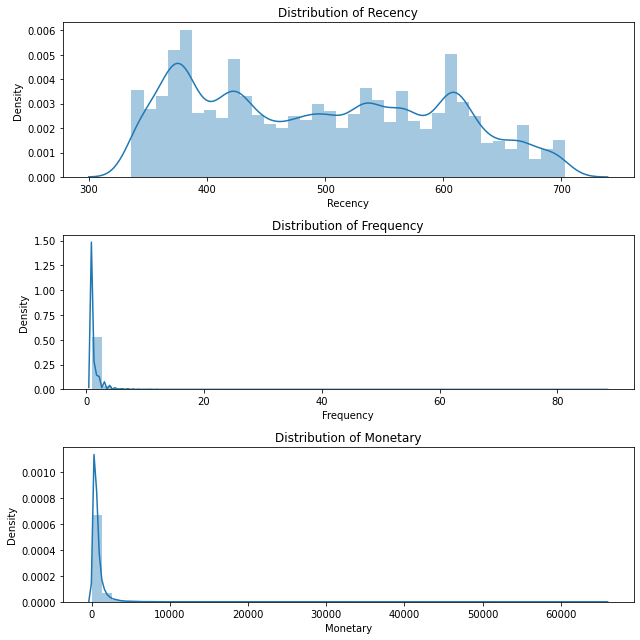

In [15]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(rfm_table,'Recency')

plt.subplot(3, 1, 2)
check_skew(rfm_table,'Frequency')

plt.subplot(3, 1, 3)
check_skew(rfm_table,'Monetary')

plt.tight_layout()

In [16]:
df_rfm_log = rfm_table.copy()

In [17]:
df_rfm_log.head()

,UserID,Recency,Frequency,Monetary
0,-18822,583,1,612.2142
1,-18786,452,1,1257.8895
2,-18639,452,1,672.6726
3,-18511,338,7,2421.0576
4,-18405,668,1,315.6570


Recency's: Skew: -0.05003943606399995, : SkewtestResult(statistic=-4.224975904134859, pvalue=2.38966345666417e-05)
Frequency's: Skew: 2.9596140337368597, : SkewtestResult(statistic=137.94502652538443, pvalue=0.0)
Monetary's: Skew: 0.2140121590927152, : SkewtestResult(statistic=17.880186199906454, pvalue=1.6827409186228384e-71)


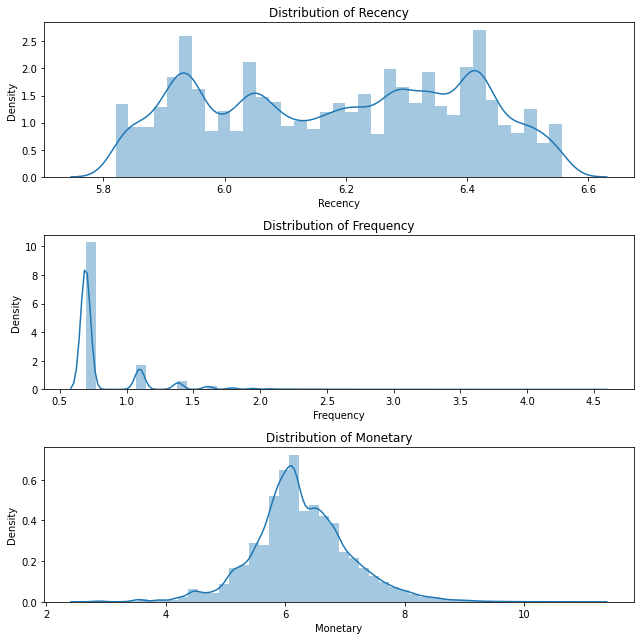

In [18]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()

In [19]:
!pip install feature_engine

import feature_engine

from feature_engine.outliers import Winsorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.1 MB/s 


In [20]:
windsoriser = Winsorizer(tail='both', # cap left, right or both tails 
                          fold=2,
                           variables=[ 'Recency', 'Frequency', 'Monetary']
                        )
windsoriser.fit(df_rfm_log)

Winsorizer(fold=2, tail='both', variables=['Recency', 'Frequency', 'Monetary'])

In [21]:
df_rfm_log = windsoriser.transform(df_rfm_log)

In [22]:
df_rfm_log = df_rfm_log.drop(['UserID'], axis=1)

In [23]:
scaler = StandardScaler()

scaler.fit(df_rfm_log)

#Scale and transfer the data
RFM_Table_scaled = scaler.transform(df_rfm_log)

In [24]:
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

,Recency,Frequency,Monetary
0,0.891891,-0.502409,0.207930
1,-0.334072,-0.502409,1.180017
2,-0.334072,-0.502409,0.335010
3,-1.733224,2.732471,2.064415
4,1.547725,-0.502409,-0.685263


In [25]:
RFM_Table_scaled.isnull().sum()

Recency      0
Frequency    0
Monetary     0
dtype: int64

In [26]:
RFM = RFM_Table_scaled.to_csv("/content/drive/MyDrive/Skripsi/Data/RFM_SS.csv")

# ELBOW, SSE

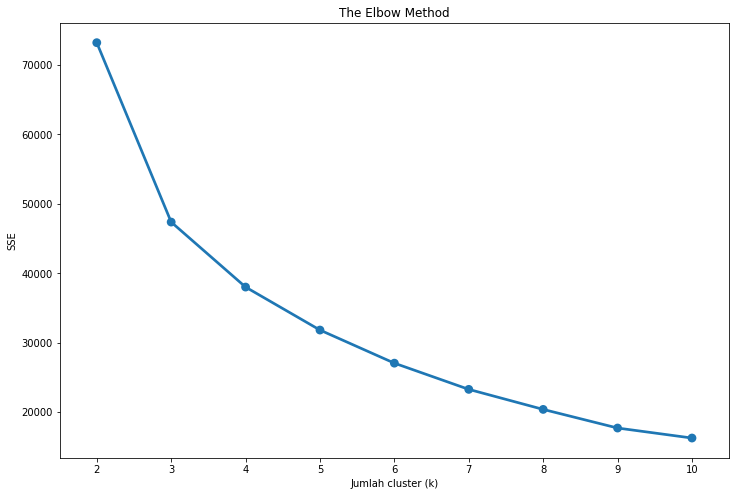

In [27]:
from sklearn.cluster import KMeans
sse = {}
X = RFM_Table_scaled
# Fit KMeans and calculate SSE for each k
for k in range(2, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(X)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
# Plotting the elbow plot
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('Jumlah cluster (k)'); 
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [28]:
sse

{2: 73203.06125534378,
 3: 47373.7041252124,
 4: 38013.6439028367,
 5: 31822.857968113007,
 6: 27056.51498076994,
 7: 23282.509879583744,
 8: 20397.63811925717,
 9: 17715.266536087955,
 10: 16274.894759199678}

# CLUSTERING

## Centroid Initation

In [29]:
import random
from math import ceil
import random as rd
import copy

In [30]:
df = RFM_Table_scaled
x = 'Recency'
y = 'Frequency'
z = 'Monetary'

In [31]:
def Initiate_Centroid(df,x,y,z,k):
    random.seed(10)
    centroids = {i+1 : [random.choices(df[x]), random.choices(df[y]), random.choices(df[z])] for i in range(k)}
    return centroids

In [32]:
#Test
#Baris = cluster
#Colom = variabel
k=3
cen = Initiate_Centroid(df,x,y,z,k)
for i in cen:
    print(cen[i])

[[0.42360886514694407], [-0.5024085274259974], [-0.24635586815532737]]
[[1.5908186660039918], [-0.5024085274259974], [-0.4922946685294507]]
[[0.05470877732431485], [-0.5024085274259974], [-0.3311070672884226]]


## Calculate Distance √((x1-x2)² + (y1-y2)²

In [33]:
def Cal_Dist(df,x,y,z,centroid):
    for i in centroid.keys():
        #menambahkan kolom i(1,2,..,n) yaitu jarak antara objek x dan y dengan masing masing centroid
        df[str(i)] = np.sqrt((df[x] - centroid[i][0]) ** 2 + (df[y] - centroid[i][1]) ** 2 + (df[z] - centroid[i][2]) ** 2 ) 
    return df #jarak antar variabel dg centroid

In [34]:
df2 = Cal_Dist(df,x,y,z,cen)
df2

,Recency,Frequency,Monetary,1,2,3
0,0.891891,-0.502409,0.207930,0.652429,0.989350,0.995708
1,-0.334072,-0.502409,1.180017,1.615122,2.549869,1.560336
2,-0.334072,-0.502409,0.335010,0.955022,2.095146,0.771274
3,-1.733224,2.732471,2.064415,4.522835,5.296270,4.404506
4,1.547725,-0.502409,-0.685263,1.206763,0.197722,1.534446
...,...,...,...,...,...,...
42807,-1.761783,-0.502409,-0.794295,2.253037,3.366176,1.874616
42808,-1.761783,-0.502409,0.024976,2.202171,3.392271,1.851064
42809,-1.761783,-0.502409,0.387973,2.275590,3.466238,1.953642
42810,-1.761783,-0.502409,2.154281,3.246382,4.271335,3.078441


## Menentukan Keanggotaan

In [35]:
def df_membership(df,centroid):
  df['index cluster'] = (df.loc[:, ['{}'.format(i) for i in centroid.keys()]].idxmin(axis=1)).astype('int') 

  #colmap = ['pink','orange','green','red','purple','brown','blue','gray','olive','cyan','black']
  #df['color'] = df['index cluster'].map(lambda x: colmap[x])
  return df

In [36]:
df2 = df_membership(df2,cen)
df2

,Recency,Frequency,Monetary,1,2,3,index cluster
0,0.891891,-0.502409,0.207930,0.652429,0.989350,0.995708,1
1,-0.334072,-0.502409,1.180017,1.615122,2.549869,1.560336,3
2,-0.334072,-0.502409,0.335010,0.955022,2.095146,0.771274,3
3,-1.733224,2.732471,2.064415,4.522835,5.296270,4.404506,3
4,1.547725,-0.502409,-0.685263,1.206763,0.197722,1.534446,2
...,...,...,...,...,...,...,...
42807,-1.761783,-0.502409,-0.794295,2.253037,3.366176,1.874616,3
42808,-1.761783,-0.502409,0.024976,2.202171,3.392271,1.851064,3
42809,-1.761783,-0.502409,0.387973,2.275590,3.466238,1.953642,3
42810,-1.761783,-0.502409,2.154281,3.246382,4.271335,3.078441,3


## Menentukan Centroid Baru

In [37]:
def rearrange_centroid(df,centroid):
  for i in centroid.keys():
    centroid[i][0] = np.mean(df[df['index cluster'] == i][x])
    centroid[i][1] = np.mean(df[df['index cluster'] == i][y])
    centroid[i][2] = np.mean(df[df['index cluster'] == i][z])
  return centroid

## Clustering 

In [38]:
def clusterisasi(df,x,y,z,k):
  centroid = Initiate_Centroid(df,x,y,z,k)
  df2 = copy.deepcopy(df)
  df2 = Cal_Dist(df2,x,y,z,centroid)
  df2 = df_membership(df2,centroid)
  centroid = rearrange_centroid(df2,centroid)
  while (True):
    oldcentroid = copy.deepcopy(centroid)
    df2 = Cal_Dist(df2,x,y,z,centroid)
    df2 = df_membership(df2,centroid)
    centroid = rearrange_centroid(df2,centroid)
    if (oldcentroid == centroid):
      break
  return (df2,centroid)

In [39]:
print(clusterisasi(df2,x,y,z,k))

(        Recency  Frequency  Monetary         1         2         3  \
0      0.891891  -0.502409  0.207930  2.906646  0.656315  1.737063   
1     -0.334072  -0.502409  1.180017  2.346865  2.049338  1.393944   
2     -0.334072  -0.502409  0.335010  2.498987  1.472136  0.666500   
3     -1.733224   2.732471  2.064415  1.738447  4.834518  4.009135   
4      1.547725  -0.502409 -0.685263  3.646225  0.681524  2.424416   
...         ...        ...       ...       ...       ...       ...   
42807 -1.761783  -0.502409 -0.794295  3.309842  2.697975  1.159353   
42808 -1.761783  -0.502409  0.024976  2.892897  2.716296  0.962190   
42809 -1.761783  -0.502409  0.387973  2.766249  2.802031  1.081498   
42810 -1.761783  -0.502409  2.154281  2.815254  3.730215  2.473274   
42811 -1.761783  -0.502409 -0.971983  3.419520  2.726665  1.269633   

       index cluster  
0                  2  
1                  3  
2                  3  
3                  1  
4                  2  
...              ...

In [40]:
df2, centroid = clusterisasi(df,x,y,z,k)

In [41]:
cluster = df2[['Recency', 'Frequency', 'Monetary', 'index cluster']]

In [42]:
rfm_table.index = pd.RangeIndex(len(rfm_table.index))
RFM_km = pd.concat([rfm_table, cluster], axis=1)
RFM_km.columns = ['UserID', 'Recency', 'Frequency', 'Monetary','1','2','3','cluster']
RFM_km.head()

,UserID,Recency,Frequency,Monetary,1,2,3,cluster
0,-18822,583,1,612.2142,0.891891,-0.502409,0.207930,2
1,-18786,452,1,1257.8895,-0.334072,-0.502409,1.180017,3
2,-18639,452,1,672.6726,-0.334072,-0.502409,0.335010,3
3,-18511,338,7,2421.0576,-1.733224,2.732471,2.064415,1
4,-18405,668,1,315.6570,1.547725,-0.502409,-0.685263,2


In [43]:
centroid = RFM_km.to_excel("/content/drive/MyDrive/Skripsi/HasilData/centroid.xlsx")

In [44]:
RFM_km = RFM_km[['UserID','Recency', 'Frequency', 'Monetary', 'cluster']]
RFM_km

,UserID,Recency,Frequency,Monetary,cluster
0,-18822,583,1,612.2142,2
1,-18786,452,1,1257.8895,3
2,-18639,452,1,672.6726,3
3,-18511,338,7,2421.0576,1
4,-18405,668,1,315.6570,2
...,...,...,...,...,...
42807,295079,336,1,291.1140,3
42808,295083,336,1,534.5757,3
42809,295087,336,1,699.5970,3
42810,295093,336,1,2587.5855,3


In [45]:
RFM = RFM_km.to_excel("/content/drive/MyDrive/Skripsi/HasilData/RFM_cluster.xlsx")

# EVALUATION

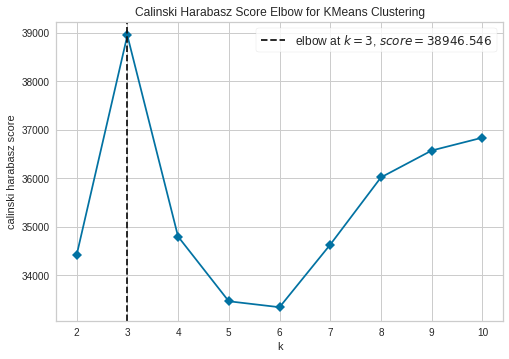

In [46]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,11), metric='calinski_harabasz', timings=False
)

visualizer.fit(X)
visualizer.show() 

In [47]:
from sklearn.metrics import calinski_harabasz_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(RFM_Table_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    ch_index = calinski_harabasz_score(RFM_Table_scaled, cluster_labels)
    print("For n_clusters={0}, the calinski harabasz score is {1}".format(num_clusters, ch_index))

For n_clusters=2, the calinski harabasz score is 34416.50303333377
For n_clusters=3, the calinski harabasz score is 38946.546230043554
For n_clusters=4, the calinski harabasz score is 34800.177975044615
For n_clusters=5, the calinski harabasz score is 33465.90923706565
For n_clusters=6, the calinski harabasz score is 33343.496097262476
For n_clusters=7, the calinski harabasz score is 34633.793624023
For n_clusters=8, the calinski harabasz score is 36020.557659535036
For n_clusters=9, the calinski harabasz score is 36573.59091126616
For n_clusters=10, the calinski harabasz score is 36839.29201596131


# ANALISIS CLUSTER

In [48]:
# Melakukan grouping data 
group_cluster = RFM_km.groupby('cluster')['UserID'].count()
group_cluster

cluster
1     8653
2    18712
3    15447
Name: UserID, dtype: int64

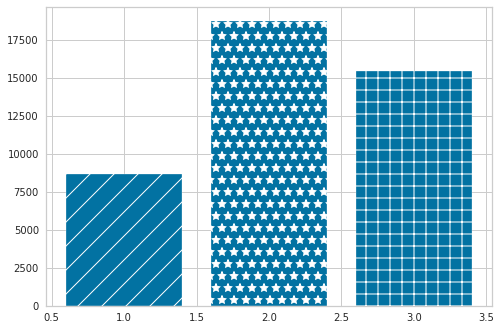

<Figure size 432x288 with 0 Axes>

In [80]:
df_group_cluster = (group_cluster).reset_index()
df_group_cluster.rename(columns = {'UserID': 'Customers', 'cluster':'Segmen'}, inplace = True)

x= df_group_cluster['Customers']
y= df_group_cluster['Segmen']

patterns = ['*','o','/']
bars = plt.bar(y,x)

bars[0].set_hatch('/')
bars[1].set_hatch('*')
bars[2].set_hatch('+')

plt.figure(figsize=(6,4))

plt.show()

# sns.barplot(data = df_group_cluster, x='Segmen', y='Customers', patterns = patterns )

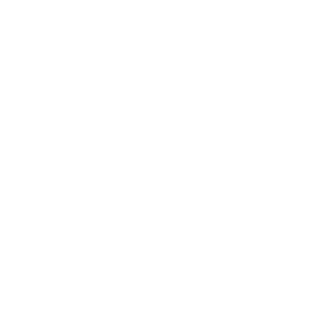

In [87]:
label = df_group_cluster['Segmen']

hatches = ['o' if value==min(label) else 'O' if value==max(label) else '' for value in label]


patches = plt.pie(label)
for i in range(len(patches[0])):
    patches[0][i].set(hatch = hatches[i], fill=False)
plt.show()



# plt.pie(data = df_group_cluster, x= 'Customers' ,labels= label, startangle=90, autopct='%1.1f%%')
# plt.axis('equal')
# plt.show()

## RFM MEAN

In [52]:
# Calculate average RFM values and size for each cluster
RFM_mean = RFM_km.groupby(['cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean']}).round()
RFM_mean

,Recency,Frequency,Monetary
,mean,mean,mean
cluster,,,
1,442.0,3.0,1763.0
2,588.0,1.0,458.0
3,412.0,1.0,575.0


## RFM MIN

In [53]:
RFM_min = RFM_km.groupby(['cluster']).agg({'Recency': 'min',
                                                    'Frequency': 'min',
                                                    'Monetary': ['min'],})
RFM_min

,Recency,Frequency,Monetary
,min,min,min
cluster,,,
1,336,2,152.4096
2,457,1,13.8996
3,336,1,16.7670


## RFM MAX

In [54]:
RFM_max = RFM_km.groupby(['cluster']).agg({'Recency': 'max',
                                                    'Frequency': 'max',
                                                    'Monetary': ['max'],})
RFM_max

,Recency,Frequency,Monetary
,max,max,max
cluster,,,
1,703,88,65587.2795
2,703,3,13776.5934
3,537,2,32034.7143
